# Deep Hedging of a European Vanilla Call

## 1. Overview
We implement the **Deep Hedging** algorithm from Bühler et al ([paper](https://arxiv.org/pdf/1802.03042) - 2019), which uses a sequence of deep feed forward neural networks (DFNN) to learne optimal hedge ratios $\delta_{t}$ in order to minimize a risk measure (we chose terminal quadratic loss!) by trading in the underlying $S_t$.<br>

Compared to the [implementation](https://gist.github.com/jteichma/29ffd4566e1f4349ce5f6a9c87bbbda1) of Teichmann, we introduce 2 key modifications:<br><br>
&emsp;&emsp;1. **Increased training data variance**:<br>
&emsp;&emsp;We randomize $K$, $S_0$, $\mu$, $\sigma$ for each path, hence have a different stock with different characteristics. This builds a more realistic training set, but also makes training loss reduction more challenging!<br><br>
&emsp;&emsp;2. **Exogenous price input**:<br> 
&emsp;&emsp; Asset prices $S_t$ are generated outside the computational graph & fed in model at each timestep, reflecting that stock prices come from ***the market***, rather than being simulated in the model.

## 2. Optimization problem 
We build a sequence of networks to predict hedges $\delta_{t}=F_t(S_t,\delta_{t-1};\theta_t)$ aiming to minimize squared hedging error between terminal portfolio value, premium and payoff. The problem statement is:
$$\inf_{\theta_t\ \in \Theta} \ \ \left(C_0 + \sum_{t=0}^{n-1} F_t(S_t,\delta_{t-1};\theta_t) (S_{t+1} - S_t) - \text{max}(S_T-K,0)\right)^2 $$
With $C_0$ as the premium, $K$ the strike, $S_t$ the underlying, $\delta_{t}$ the hedge quantity, $\max(S_T - K, 0)$ the payoff and $F_t$ the approximator of $\delta_t$.

## 3. Assumptions
- Complete market described by Black Scholes model (no dividends, no transaction costs, no arbitrage, no short selling restrictions, $\mu$, $r$ and $\sigma$ are constant)
- $S_t$ follows a geometric Brownian motion
- We work under risk neutral pricing with $\mu=r$
- A European vanilla call is considered
- The hedge portfolio is self financing

## 3. Design
### 3.1. Initialize start values, sample inputs & create training data
- Normalize the year by $T=1$
- Set timestep index by $t=0,...,n-1$
- Set path index by $i=1,...,k$ 
- Set stepsize by $dt=\frac{T}{n-1}$
- Set $S_{0_{\min}}, S_{0_{\max}} \in \mathbb{R}_+$ with $S_{0_{\min}} \leq S_{0_{\max}}$<br> 
- Set $\mu_{\min}, \mu_{\max} \in \mathbb{R}_+$ with $\mu_{\min} \leq \mu_{\max}$ $<br> 
- Set $\sigma_{\min}, \sigma_{\max} \in \mathbb{R}_+$ with $\sigma_{\min} \leq \sigma_{\max}$<br> 
- For $i=1,...,k$<br>
&emsp;&emsp;&emsp;- sample initial prices by $S_0^i \sim \mathcal{U(S_{0_{\min}}, S_{0_{\max}})}$<br>
&emsp;&emsp;&emsp;- sample strikes by $K^i \sim \mathcal{U(0.8\cdot S_0^i, 1.2\cdot S_0^i)}$<br>
&emsp;&emsp;&emsp;- sample drifts by $\mu^i \sim \mathcal{U(\mu_{\min},\mu_{\max})}$<br>
&emsp;&emsp;&emsp;- sample sigmas by $\sigma^i \sim \mathcal{U(\sigma_{\min},\sigma_{\max})}$<br>
&emsp;&emsp;&emsp;- For $t=0,...,n-1$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- sample random numbers by $Z_{t}^{i} \sim \mathcal{N(0,1)}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- calculate (via $S_0^i$) stock prices by $S_{t+1}^{i} = S_{t}^{i} \cdot \exp\left( \left( \mu^{i} - \frac{1}{2} (\sigma^{i})^2 \right) dt + \sigma^{i} \sqrt{dt} \cdot Z_{t}^{i} \right)$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- calculate call prices $C_{t}^{i}$ by<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$d^{i}_{1_t}=\frac{\log(\frac{S_t^i}{K^i})+(\mu^i+\frac{(\sigma^{i})^2}{2})\cdot(T-dt\cdot t)}{(\sigma^i\cdot \sqrt{T - dt \cdot t})}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$d^{i}_{2_t}=d^{i}_{1_t}-\sigma^i\cdot \sqrt{T - dt \cdot t}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$(\delta_{t}^i)^{BS}= \Phi(d^{i}_{1_t})$ (these are the BS deltas!)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$C_t^i=S_t^i \cdot \delta_t^i -K^i \cdot \exp(-\mu^i\cdot(T - dt \cdot t))\cdot \Phi(d^{i}_{2_t})$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; - normalize $S_t^i$ and $C_t^i$ by moneyness $\tilde{S}_t^i=\frac{S_t^i}{K^i}, \tilde{C}_t^i=\frac{C_t^i}{K^i}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- define features by $x_t^{0,i}=(\tilde{S}_t^i,\delta_{t-1}^i)$<br>
&emsp;&emsp;&emsp;- For $t = n$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- calculate payoff by $C_n^i=\max(S_n^{i}-K^{i},0)$<br>
&emsp;&emsp;&emsp; - normalize $K^i$ also by moneyness $\tilde{K}^i=\frac{K^i}{K^i}=1$<br>
&emsp;&emsp;&emsp; - define labels by $y^i=0$<br> 
&emsp;&emsp;&emsp; - define boundary deltas by $\delta_{-1}^i=0=\delta_{n}^i$ (these are the first model deltas)<br> 
- Define training set by $\mathcal{D} = \left\{ \left( (\tilde{S}_t^i)_{t=0}^{n-1},\, \tilde{K}^i,\, \mu^i,\, \sigma^i,\, \tilde{C}_0^i,\, \delta_{-1}^i,\, y^i \right) \;\middle|\; i = 1, ..., k \right\}$<br>

### 3.2. Define networks (fixed architecture)
- For $t = 0,...,n-1$ ($n$ networks!)<br>
&emsp;&emsp;&emsp;- set network layers by $l_t=(l_t^0, l_t^1,...,l_t^{p})$ with  $p\in \mathbb{N}$ with $l_t^0$ as input layer<br>
&emsp;&emsp;&emsp;- set number of neurons in a layer by $v_t=(v_t^{0},v_t^{1},...,v_t^{p})$ with $v_t^j=|l_t^j| \in \mathbb{N}$<br>   
&emsp;&emsp;&emsp;- set activations between layers by $f_t^j:\mathbb{R}^{v_t^{j}} \to \mathbb{R}^{v_t^{j}}$ (i.e. ReLU, sigmoid, tanh, etc.)<br>
&emsp;&emsp;&emsp;- construct networks by $F_t(\bold{x_t}^0;\, \theta_t) = f_t^p\Big( \mathbf{A}_t^{p} f_t^{p-1} \big( ... f_t^1(\mathbf{A}_t^1 (\bold{x_t}^0) + \mathbf{b}_t^1)... \big) + \mathbf{b}_t^{p} \Big)$ with input vector $\bold{x}_t^0 \in \mathbb{R}^{v_t^0}$<br>
&emsp;&emsp;&emsp;- For $j = 1,...,p$<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- sample $a_t^{j},b_t^{j}\sim \mathcal{N}(\mu,\sigma)$ to retrieve $\theta_t^j=(\bold{A_t}^{j},\bold{b_t}^{j})$ with $\bold{A_t}^{j}\in \mathbb{R}^{v_t^{j}\times v_t^{j-1}}$ and $\bold{b_t}^{j}\in \mathbb{R}^{v_t^{j}}$ (notice $\mu,\sigma$ are different than above Black Scholes values!)<br>

### 3.3. Define loss function for each path
- For $i=1,...,k$<br>
&emsp;&emsp;&emsp;- set $\mathcal{L}^i(\theta) =\left[\underbrace{\tilde{C}_0^i + \sum_{t=0}^{n-1} F_t(\bold{x}^{0,i}_t; \theta_t) \cdot (\tilde{S}_{t+1}^i- \tilde{S}_{t}^i)- \max(\tilde{S}_{T}^i - \tilde{K}^i, 0)}_{\text{terminal Pnl}}-\underbrace{y^i}_{\text{label}}\right]^2$ 

### 3.4. Set hyperparameters
- Define batch size by $m=\lceil \tfrac{k}{b} \rceil \in \mathbb{N}$
- Define number of epochs by $E \in \mathbb{N}$ 
- Define learning rate by $\eta \in \mathbb{R_+}$<br>
- Define mean decay rate $\beta_1\in [0,1]$ (only for Adam optimizer)
- Define variance decay rate $\beta_2\in [0,1]$ (only for Adam optimizer)
- Define stability constant $\varepsilon=10^{-7}$  (only for Adam optimizer)
- Define inital moments $m_0=(0,...,0)=v_0$ with $\bold{dim}(m_0)=\bold{dim}(\theta_t) =\bold{dim}(v_0)$<br>

### 3.5. Split training data in batches
- Divide $\mathcal{D}$ in $b$ disjoint batches, each of size $m$ by $\mathcal{D}=\bigcup_{q=1}^{b} B_q$

### 3.6. Define batch loss function
- Define **batch loss** as MSE (average loss per batch) by $\mathcal{L}^{q}_{batch}(\theta) = \frac{1}{|B_q|} \sum_{\xi \in B_q} \mathcal{L}^{\xi}(\theta)$ for $q = 1, ..., b$

### 3.7. Training algorithm (computational graph)
- Set $m_t = \mathbf{0} \in \mathbb{R}^{\dim(\theta_t)}$ (initial first moment - used in ADAM)<br>
- Set $v_t = \mathbf{0} \in \mathbb{R}^{\dim(\theta_t)}$ (initial second moment - used in ADAM)<br>
- Set $u=0$ (step counter - used in ADAM)<br>
- For $h=1,...,E$ (epochs)<br>
&emsp;&emsp;&emsp; <span style="color:#de910b;">FORWARD PASS</span><br>
&emsp;&emsp;&emsp;- For $q=1,...,b$ (batches, each of $m$ paths)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- For $i=1,...,m$ (paths in each batch)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $Pnl_{0}^{q,i}=\tilde{C}_{0}^{q,i}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\delta_{-1}^{q,i}= 0$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $y^{q,i}= 0$ (labels)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- For $t=0,...,n-1$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\delta_{t}^{q,i}=F_t((\delta_{t-1}^{q,i}, \tilde{S}_{t}^{q,i});\theta_t)$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$Pnl_{t+1}^{q,i}=Pnl_{t}^{q,i}+\delta_{t}^{q,i}\cdot(\tilde{S}_{t+1}^{q,i}-\tilde{S}_{t}^{q,i})$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\tilde{C}_{T}^{q,i}=\max(\tilde{S}_{T}^{q,i}-\tilde{K}^{q,i},0)$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$Pnl_T^{q,i}=Pnl_{n}^{q,i}-\tilde{C}_{T}^{q,i} $<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathcal{L}_{path}^{q,i}=(Pnl_T^{q,i}-y^{q,i})^2$ (path loss)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathcal{L}_{batch}^q=\frac{1}{m}\sum_{i=1}^{m}\mathcal{L}_{path}^{q,i}$ (batch loss)<br>
&emsp;&emsp;&emsp; <span style="color:#de910b;">BACKPROPAGATION</span><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- For $t=0,...,n-1$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\nabla_{\theta_{t}} \mathcal{L}_{batch}^q =\frac{\partial \mathcal{L}_{batch}^q}{\partial \theta_t}$<br>
&emsp;&emsp;&emsp; <span style="color:#de910b;">PARAMETER UPDATE (using ADAM)</span><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;- For $t=0,...,n-1$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$m_t \leftarrow \beta_1 \cdot m_t + (1 - \beta_1) \cdot \frac{\partial \mathcal{L}_{batch}^q}{\partial \theta_t}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$v_t \leftarrow \beta_2 \cdot v_t + (1 - \beta_2) \cdot (\frac{\partial \mathcal{L}_{batch}^q}{\partial \theta_t})^2$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\hat{m}_t = \frac{m_t}{1 - \beta_1^u}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\hat{v}_t = \frac{v_t}{1 - \beta_2^u}$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\theta_t \leftarrow \theta_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}$ (applied elementwise!)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$u\leftarrow u+1$ (counter of parameter updates after a batch)

## 4. How to run a prediction on the provided model deep_hedging_64.py

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


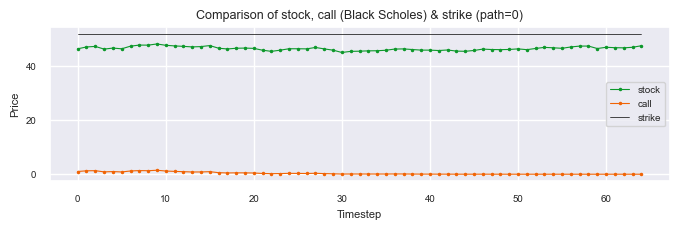

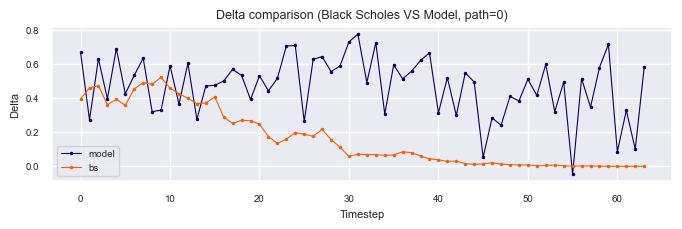

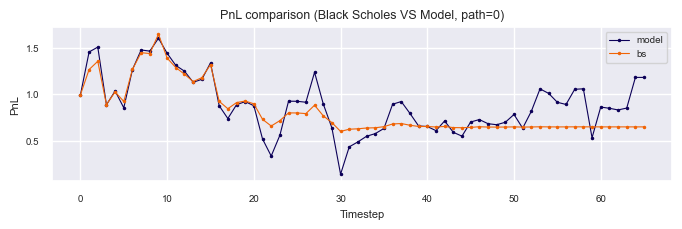

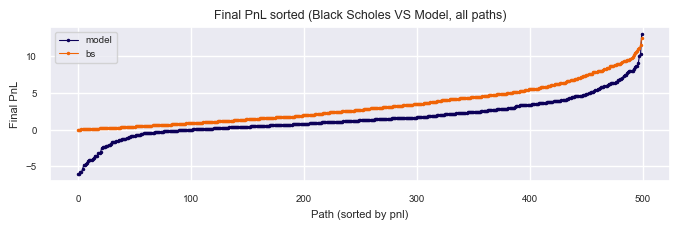

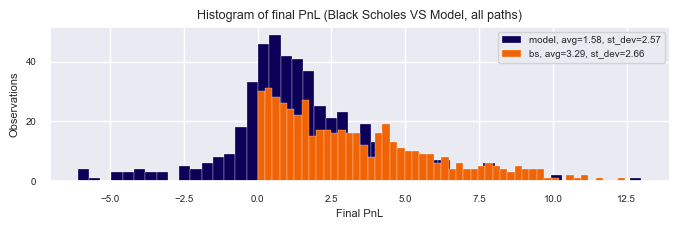

In [ ]:
from deep_call_hedger import main_prediction     # import the module main_prediction

nr_of_paths=500                                  # minimum is 1, higher numbers need more compute, the model "deep_hedging_64" was trained on 50000
nr_of_timesteps=64                               # must be 64 days, except you trained & saved a new model on different timesteps (see "5. How to train a new model") 
T=1                                              # must always be 1
mu_min=0.05                                      # must be >0 
mu_max=0.2                                       # must be >=mu_min
sigma_min=0.01                                   # must be >0
sigma_max=0.2                                    # must be >=sigma_min
S0_min=1                                         # must be >0
S0_max=70                                        # must be >=S0_min
model_path=r"/path/deep_hedging_64.keras"        # full folderpath to model, change this if you want to use another model
path_to_analyse=0                                # select a path, you want to inspect minimum is 0, maximum is nr_of_paths-1

# create main prediction object
predict=main_prediction.Main(nr_of_paths=nr_of_paths,nr_of_timesteps=nr_of_timesteps, 
                             T=T,mu_min=mu_min,mu_max=mu_max,sigma_min=sigma_min,sigma_max=sigma_max,
                             S0_min=S0_min, S0_max=S0_max, model_path=model_path,path_to_analyse=path_to_analyse)

# run the prediction and analysis 
predict.run()

# the start prediction always defaults to path_to_analyse=0, this can be changed see below!

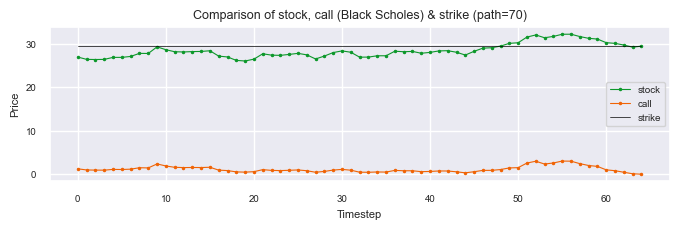

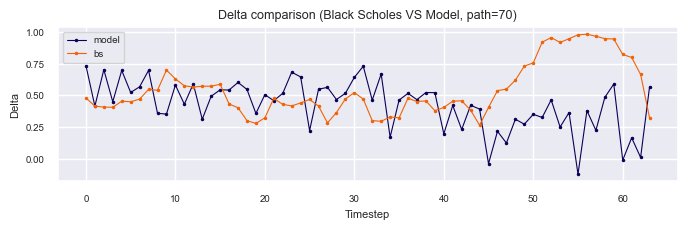

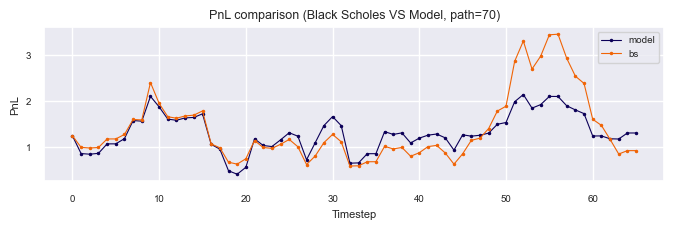

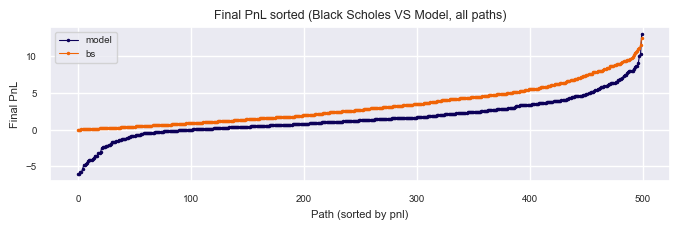

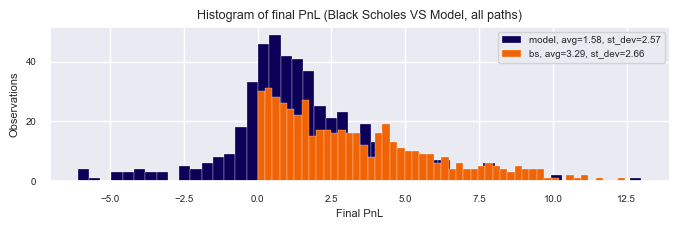

In [ ]:
predict.analyse_path(path_to_analyse=70) # set a different value for path_to_analyse, to see this path's performance

## 5. How to train a new model

In [ ]:
from deep_call_hedger import main_training          # import the module main_training

T=1                                                 # must always be 1
nr_of_timesteps=7                                   # minimum is 2, higher numbers take more time,
nr_of_paths=500                                     # minimum is 2, higher numbers take more time for compute, convergence (loss plateau) achieved around 50000!
S0_min=1                                            # must be >0
S0_max=70                                           # must be >=S0_min 
mu_min=0.01                                         # must be >0
mu_max=0.2                                          # must be >=mu_min
sigma_min=0.05                                      # must be >0
sigma_max=0.2                                       # must be >=sigma_min
nr_of_layers=2                                      # must be >=2
nr_of_neurons=[64,1]                                # each element must be >=1, while nr of all list elements must equal nr_of_layers  
activations=['tanh','linear']                       # select for each element a desire activation like: tanh,linear,relu, sigmoid, etc.
weights_mu=[0,0]                                    # each element must be >=0, while nr of all list elements must equal nr_of_layers
weights_sigma=[0.1,0.1]                             # each element must be >=0, while nr of all list elements must equal nr_of_layers
bias_mu=[0,0]                                       # each element must be >=0, while nr of all list elements must equal nr_of_layers
bias_sigma=[0,0]                                    # each element must be >=0, while nr of all list elements must equal nr_of_layers
batch_size=100                                      # must be >=1
epochs=10                                           # must be >=1
optimizer="adam"                                    # fixed optimizer is adam
loss="mean_squared_error"                           # change to a desired loss like: ???
validation_split=0.2                                # must be inside (0,1) usually 0.2 works well

# create main training object
deep_hedging=main_training.Main(T=T,
                                nr_of_timesteps=nr_of_timesteps,
                                nr_of_paths=nr_of_paths,
                                S0_min=S0_min,
                                S0_max=S0_max,
                                mu_min=mu_min,
                                mu_max=mu_max,
                                sigma_min=sigma_min,
                                sigma_max=sigma_max,
                                nr_of_layers=nr_of_layers,
                                nr_of_neurons=nr_of_neurons,
                                activations=activations,
                                weights_mu=weights_mu,
                                weights_sigma=weights_sigma,
                                bias_mu=bias_mu,
                                bias_sigma=bias_sigma,
                                batch_size=batch_size,
                                epochs=epochs,
                                optimizer=optimizer,
                                loss=loss,
                                validation_split=validation_split)

# run the training and save the model
deep_hedging.run() 

# NOTICE: The trained model name is "deep_hedging_nr_of_timesteps.keras" & it lies in the deep_call_hegder folder. 
#         Move this file then to the models folder, then you can use it to run a prediction (see "4. How to run a prediction")

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 38.0929 - val_loss: 20.4663
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.9860 - val_loss: 15.3881
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13.8560 - val_loss: 13.2318
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.6925 - val_loss: 11.9139
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.6550 - val_loss: 10.3294
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8194 - val_loss: 9.3559
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1318 - val_loss: 9.4123
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8815 - val_loss: 9.5500
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3329 - val_loss: 9.4926
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4354 - val_loss: 9.5984


(<keras.src.callbacks.history.History at 0x16693bf90>,
 <Functional name=deep_hedging, built=True>)

## 6. How to run a prediction on the new model deep_hedging_5.py

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


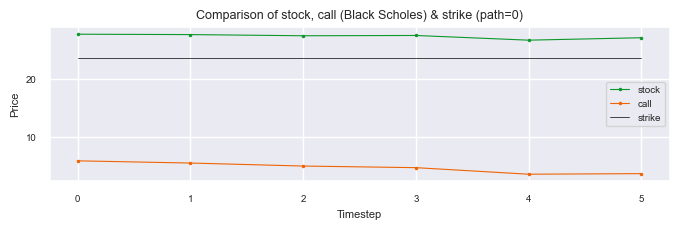

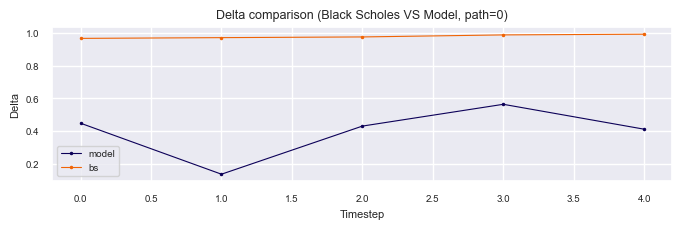

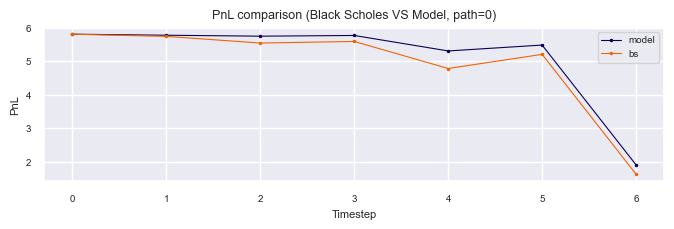

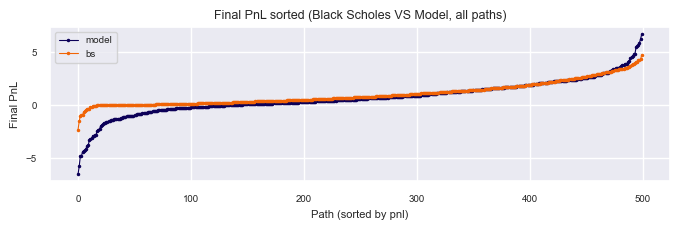

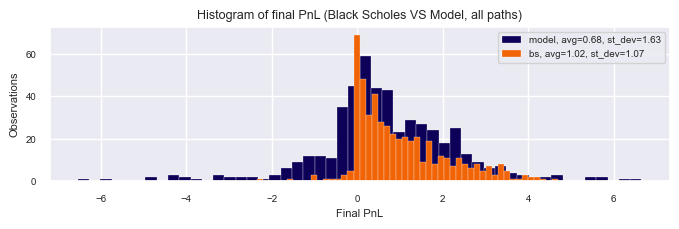

In [ ]:
# NOTICE: We moved previous created model deep_hedging_5.keras into teh models folder
from deep_call_hedger import main_prediction     

nr_of_paths=500                                  
nr_of_timesteps=5                                # make sure timesteps correspond with the new model 
T=1                                             
mu_min=0.01                                      
mu_max=0.1                                       
sigma_min=0.03                                   
sigma_max=0.15                                    
S0_min=1                                         
S0_max=55   
model_path=r"/path/deep_hedging_5.keras"         # set the correct path to the new model
path_to_analyse=0                                

predict=main_prediction.Main(nr_of_paths=nr_of_paths,nr_of_timesteps=nr_of_timesteps, 
                             T=T,mu_min=mu_min,mu_max=mu_max,sigma_min=sigma_min,sigma_max=sigma_max,
                             S0_min=S0_min, S0_max=S0_max, model_path=model_path,path_to_analyse=path_to_analyse)

predict.run()

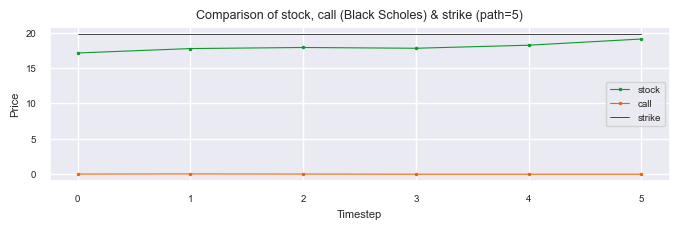

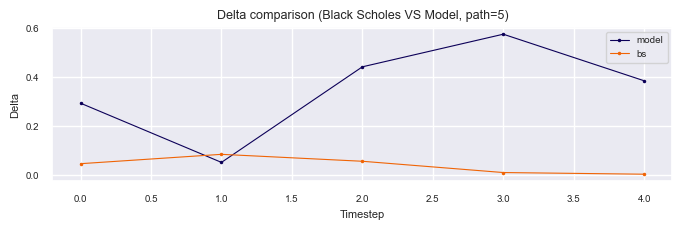

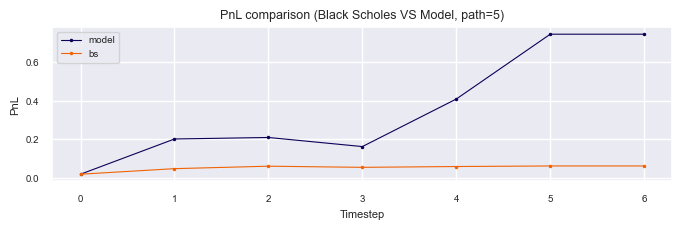

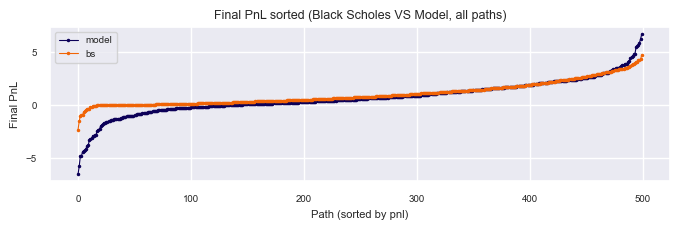

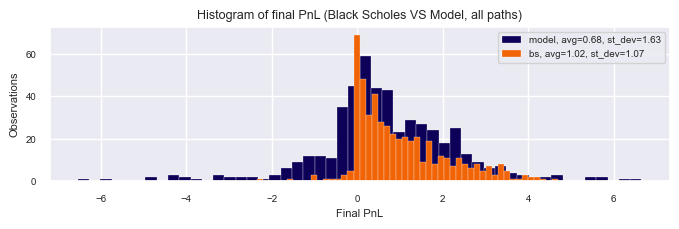

In [ ]:
predict.analyse_path(path_to_analyse=5) # set a different value for path_to_analyse, to see this path's performance